In [2]:
import pandas as pd
import ipywidgets as widgets
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf

# Read Data

In [36]:
df_raw = pd.read_csv('../data/transformed_data_raw.csv', index_col = 0)

# COMMAND ----------

# Read Data
df_view = pd.read_csv('../data/transformed_data_for_viewing.csv', index_col = 0)

# COMMAND ----------

# Hide last 200 observations for testing 
df_unseen = df_raw[-200:]
df = df_raw[:-200]

In [84]:
df

,Number_Of_Residents,Time_Spend_On_YouTube,Occupation,Mobile_Traffic
0,1,9.799509,0.459225,9.840406
1,6,41.649654,0.483232,10.516603
2,3,73.189363,0.752502,14.627861
3,2,15.098224,0.305519,9.244819
4,1,11.418807,0.190227,12.012507
...,...,...,...,...
795,2,5.124970,0.533929,10.913351
796,4,68.770110,0.586472,11.822135
797,3,16.793432,0.462200,12.342823
798,1,16.541514,0.523837,6.173813


In [38]:
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('\[', '')
df.columns = df.columns.str.replace('\]', '')


### Specify variables

variables =  ['Occupation', 'Family_Type', 'Family_Interest',
       'House_Type', 'Number_Of_Residents', 'Average_Age',
       'Distance_To_Nearest_Tower_m', 'Number_Of_Phones',
       'Number_Of_Computers', 'Number_Of_Tvs', 'Number_Of_Pets',
       'Customer_Happiness', 'Time_Spend_On_YouTube_min',
       'Time_Spend_On_TikTok_min', 'Time_Spend_On_Instagram_min',
       'Time_Spend_On_Spotify_min', 'Size_of_home_m2']

In [61]:

variables = list(df.columns)

In [62]:
variables

['Number_Of_Residents',
 'Time_Spend_On_YouTube',
 'Occupation',
 'Mobile_Traffic']

## Make sliders

In [63]:
slider_min = -10
slider_max = 10
slider_value = (slider_max+slider_min)/2

In [64]:
layout = widgets.Layout(width='auto', height='40px') #set width and height


In [65]:
sliders = { 
  i : widgets.IntSlider(
    min=slider_min,
    max=slider_max,
    step=1,
    description=i.replace("_", " ") + ': ',
    value=slider_value,
    layout=widgets.Layout(width='40%'),
    style= {'description_width': '40%'}
  ) for i in variables
}

In [70]:
for s in sliders.values():
  display(s)

IntSlider(value=3, description='Number Of Residents: ', layout=Layout(width='40%'), max=10, min=-10, style=Sli…

IntSlider(value=-5, description='Time Spend On YouTube: ', layout=Layout(width='40%'), max=10, min=-10, style=…

IntSlider(value=5, description='Occupation: ', layout=Layout(width='40%'), max=10, min=-10, style=SliderStyle(…

IntSlider(value=-2, description='Mobile Traffic: ', layout=Layout(width='40%'), max=10, min=-10, style=SliderS…

In [71]:
### Store sliders in Dataframe

# button = widgets.Button(description="Save weights")
# output = widgets.Output()

# display(button, output)

# def on_button_clicked(b):
#   #Get slider values as pandas df
#   df_weights = pd.DataFrame(columns=['variable', 'weight'])
#   counter = 0
#   for i in variables: 
#     new_name =  i.replace(' ','_')
#     df_weights.loc[counter,'variable'] = i
#     df_weights.loc[counter,'weight']= globals()[f'slider_{new_name}'].value
#     counter +=1 

#   with output:
#       print("Weights Saved")

# button.on_click(on_button_clicked)

In [72]:
# Add save button for weights and store data
get_data_button = widgets.Button(description='Save Weights')
output = widgets.Output()

def get_data(b):

  #Get slider values as pandas df
  tmp_weights = pd.DataFrame(columns=['variable', 'weight'])
  counter = 0
  with output:
    print("Weights Saved")

  for var_name, slider in sliders.items(): 
    tmp_weights.loc[counter,'variable'] = var_name
    tmp_weights.loc[counter,'weight']= slider.value
    counter +=1 
    get_data.data = tmp_weights

  print(get_data.data)

  return get_data.data

In [73]:
get_data_button.on_click(get_data)
display(get_data_button, output)

Button(description='Save Weights', style=ButtonStyle())

Output()

In [75]:
# Store weights as dataframe
df_weights = get_data.data
df_weights

,variable,weight
0,Number_Of_Residents,3
1,Time_Spend_On_YouTube,-5
2,Occupation,5
3,Mobile_Traffic,-2


## Create manual linear regression using user input

In [76]:

# Normalize weights between -1 and 1
df_weights['weight'] = df_weights['weight']/10

In [85]:
# standardizing dataframe so coefficients are -1 and 1
df_z = df.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)


In [86]:

# Store mean and std to transform back 
mean_std={}
for var in df.columns:
    mean_std[var]=(df[var].mean(), df[var].std())

In [87]:
def reverse_zscore(pandas_series, mean, std):
    '''Mean and standard deviation should be of original variable before standardization'''
    yis=pandas_series*std+mean
    return yis

var = 'Mobile_Traffic'
original_mean, original_std = mean_std[var]
original_var_series = reverse_zscore(df_z[var], original_mean, original_std)


In [88]:
df_z

,Number_Of_Residents,Time_Spend_On_YouTube,Occupation,Mobile_Traffic
0,-1.239957,-0.655820,-0.484492,0.013240
1,3.439126,0.224566,-0.312246,0.241027
2,0.631676,1.096371,1.619707,1.625961
3,-0.304140,-0.509356,-1.587303,-0.187392
4,-1.239957,-0.611060,-2.414499,0.744943
...,...,...,...,...
795,-0.304140,-0.785031,0.051492,0.374677
796,1.567493,0.974216,0.428480,0.680813
797,0.631676,-0.462497,-0.463149,0.856214
798,-1.239957,-0.469461,-0.020915,-1.221903


In [89]:
# Manually calculate y = alpha * x + beta
X = df_z.copy()
Y = X.pop(var)
for i in X.columns:
  alpha = df_weights[df_weights['variable'] == i].weight.values[0]
  X[i] = df_z[i] * alpha 
Y_pred = X.sum(axis=1)

Y_actual = df[var]
Y_pred_trans = reverse_zscore(Y_pred, original_mean, original_std)


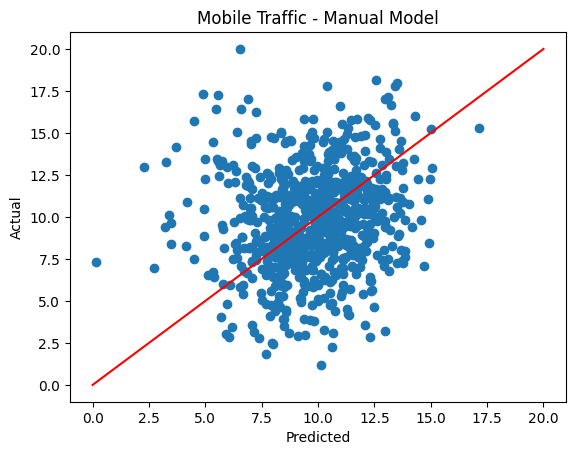

In [90]:
# plot 
import matplotlib.pyplot as plt

plt.scatter(Y_pred_trans,Y_actual)
plt.plot([0, max(max(Y_actual), max(Y_pred_trans))], [0,max(max(Y_actual), max(Y_pred_trans))], 'red')
plt.title("Mobile Traffic - Manual Model")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Evaluate model

In [91]:
# Use MAE because it's the easiest to understand ? 
get_data_button = widgets.Button(description='Evaluate your model')
output = widgets.Output()

def get_data(b):
  mape = round(np.mean(np.abs((Y_actual - Y_pred_trans)/Y_actual))*100,2)
  mae = round(sum(abs(Y_actual - Y_pred_trans))/len(Y_actual),2)
  with output:
    print("Mean Absolute Error: " + str(mae))
    print("On average your model predicts the mobile traffic to be" + str(mae) + " GB off from the actual value")
    print("That corresponds to " + str(mape) + "% off the actual value on average" )
    print("")
    if mae < 2.3:
      print("Good job! Can you beat your own record?")
    if mae >= 5:
      print("Try again! You can do better")


  return 0 

In [92]:
# DISPLAY BUTTON
get_data_button.on_click(get_data)
display(get_data_button, output)

Button(description='Evaluate your model', style=ButtonStyle())

Output()

In [93]:
%matplotlib inline
# MAGIC 
from matplotlib.pyplot import *
layout = widgets.Layout(width='auto', height='40px') #set width and height
# MAGIC 
button = widgets.Button(description="Plot your model")
out = widgets.Output()
# MAGIC 
def on_button_clicked(b):
    with out:
        Y_actual = df['Mobile_Traffic']
        Y_pred_trans = reverse_zscore(Y_pred, original_mean, original_std)
        plt.scatter(Y_pred_trans,Y_actual)
        plt.plot([0, max(max(Y_actual), max(Y_pred_trans))], [0,max(max(Y_actual), max(Y_pred_trans))], 'red')
        plt.title("Mobile Traffic - Manual Model")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()
        # show()
button.on_click(on_button_clicked)
# MAGIC 
display(button)
# MAGIC 
with out:
    print("")
    # plot([1,2],[1,2])
    # show()
out

Button(description='Plot your model', style=ButtonStyle())

Output()

## Make linear regression

In [94]:

#Create formula
# Remove Intercept
formula ='Mobile_Traffic ~ -1 + '
counter = 1
for i in  X.columns.values:
  if counter == 1:
    formula = formula + i
  else:
    formula = formula + ' + ' + i
  counter += 1

In [95]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
res = smf.ols(formula, data=df_z).fit()
lm_prediction = res.predict(df_z[:])
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         Mobile_Traffic   R-squared (uncentered):                   0.117
Model:                            OLS   Adj. R-squared (uncentered):              0.114
Method:                 Least Squares   F-statistic:                              35.36
Date:                Thu, 21 Sep 2023   Prob (F-statistic):                    1.85e-21
Time:                        14:09:33   Log-Likelihood:                         -1085.2
No. Observations:                 800   AIC:                                      2176.
Df Residuals:                     797   BIC:                                      2190.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Number_Of_Residents       0.2788      0.037      7.613      0.000       0.207       0.351
Time_Spend_On_YouTube     0.0766      0.035      2.212      0.027       0.009       0.145
Occupation                0.0760      0.036      2.139      0.033       0.006       0.146
==============================================================================
Omnibus:                        1.105   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.575   Jarque-Bera (JB):                1.076
Skew:                           0.090   Prob(JB):                        0.584
Kurtosis:                       2.998   Cond. No.                         1.57
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

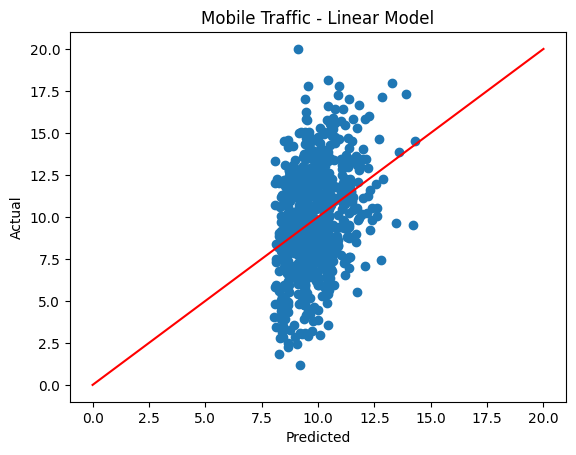

In [96]:
import matplotlib.pyplot as plt

lm_prediction_trans = reverse_zscore(lm_prediction, original_mean, original_std)

plt.scatter(lm_prediction_trans, Y_actual)
plt.plot([0, max(max(Y_actual), max(lm_prediction_trans))], [0,max(max(Y_actual), max(lm_prediction_trans))], 'red')
plt.title("Mobile Traffic - Linear Model")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [97]:
# Show case Non Linear relationship
plt.scatter(df['Distance_To_Nearest_Tower_m'], Y_actual)
plt.title("Mobile Traffic - Linear Model")
plt.ylabel("Mobile Traffic")
plt.xlabel("-")
plt.show()

KeyError: 'Distance_To_Nearest_Tower_m'

In [99]:
# Example 3d plot
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

model = smf.ols(formula='Mobile_Traffic ~ Average_Age + Number_Of_Phones', data=df)

results = model.fit()
x, y = model.exog_names[1:]

x_range = np.arange(df[x].min(), df[x].max())
print(x_range.shape)
y_range = np.arange(df[y].min(), df[y].max())
print(y_range.shape)

X, Y = np.meshgrid(x_range, y_range)

exog = pd.DataFrame({x: X.ravel(), y: Y.ravel()})
Z = results.predict(exog = exog).values.reshape(X.shape)
y_pred = results.predict(df[model.exog_names[1:]])

fig = plt.figure(figsize=plt.figaspect(1)*2)
ax = plt.axes(projection='3d')
ax.scatter(df[x].values, df[y].values, df[model.endog_names].values, label="Actual")
ax.scatter(df[x].values, df[y].values, y_pred, label="Pred")

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha = 0.4)
ax.legend()
plt.show()

PatsyError: Error evaluating factor: NameError: name 'Average_Age' is not defined
    Mobile_Traffic ~ Average_Age + Number_Of_Phones
                     ^^^^^^^^^^^

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# import matplotlib.pyplot as plt
# import numpy as np

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# X = np.arange(-5, 5, 0.25)
# Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)
# surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
# ax.set_zlim(-1.01, 1.01)

# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()